Load dependencies

In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os
import cv2
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
import seaborn as sn

In [ ]:
Load data

In [2]:
!git clone https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet.git

Cloning into 'Brain-Tumor-Classification-DataSet'...
remote: Enumerating objects: 3039, done.
remote: Total 3039 (delta 0), reused 0 (delta 0), pack-reused 3039
Receiving objects: 100% (3039/3039), 79.25 MiB | 20.30 MiB/s, done.
Checking out files: 100% (3264/3264), done.


File Paths

In [3]:
data_dir = 'Brain-Tumor-Classification-DataSet'
train_dir = data_dir+'/Training/'
test_dir = data_dir+'/Testing/'
labels = ['no_tumor','glioma_tumor','meningioma_tumor','pituitary_tumor']

Load data as np arrays

In [4]:
x_train = []
y_train = []
x_test = []
y_test = []
im_size = 150

for i in os.listdir(train_dir):
    for j in os.listdir(train_dir+i):
        x_train.append(cv2.resize(cv2.imread(train_dir+i+'/'+j),(im_size,im_size)))
        y_train.append(labels.index(i))
for i in os.listdir(test_dir):
    for j in os.listdir(test_dir+i):
        x_test.append(cv2.resize(cv2.imread(test_dir+i+'/'+j),(im_size,im_size)))
        y_test.append(labels.index(i))
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


Perform one hot encoding

In [5]:
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)
y_train = np.array(y_train)
x_train = np.array(x_train)
y_test = np.array(y_test)
x_test = np.array(x_test)
x_train, y_train = shuffle(x_train,y_train, random_state=1234)
x_test, y_test = shuffle(x_test, y_test, random_state=1234)

Verify the size of training and testing sets

In [6]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2870, 150, 150, 3)
(2870, 4)
(394, 150, 150, 3)
(394, 4)


Create validation set

In [7]:
VALID_RATIO = 0.9
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, train_size=VALID_RATIO, shuffle=True)

Visualize class distribution

In [8]:
y = dict()
y[0] = []
y[1] = []
y[2] = []
y[3] = []
for set_name in (y_train, y_valid, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))
    y[2].append(np.sum(set_name == 2))
    y[3].append(np.sum(set_name == 3))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='no_tumor',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='glioma_tumor',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
trace2 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[2],
    name='meningioma_tumor',
    marker=dict(color='#EEC900'),
    opacity=0.7
)
trace3 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[3],
    name='pituitary_tumor',
    marker=dict(color='#66CDAA'),
    opacity=0.7
)
data = [trace0, trace1,trace2,trace3]
layout = go.Layout(
    title='Class distribution in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'},
    font=dict(size=20)
)
fig = go.Figure(data,layout)
iplot(fig)

Plot some images

In [9]:
def plot_samples(x, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = x[np.argwhere(y == index)][:n]
        j = 5
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]),fontsize=28)
        plt.show()

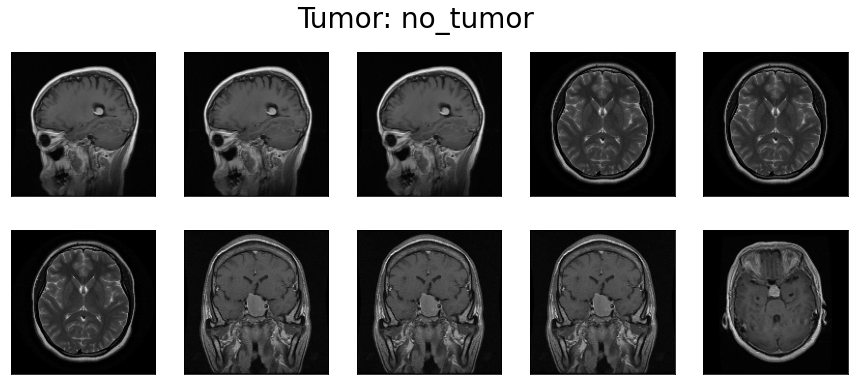

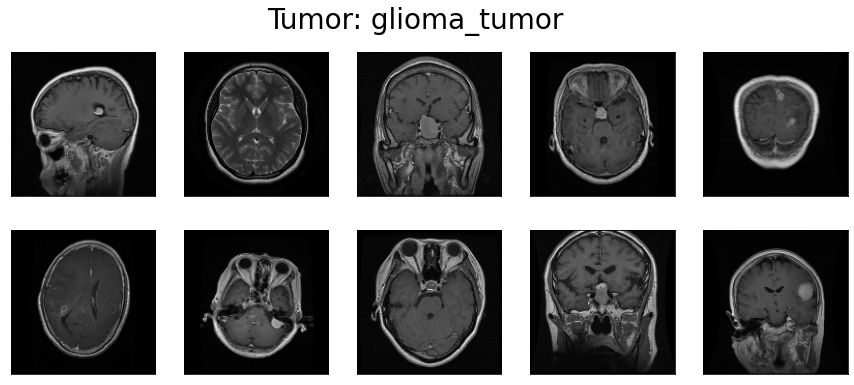

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

In [10]:
plot_samples(x_train, y_train, labels, 10)

Data augmentation

In [11]:
train_datagen = ImageDataGenerator(
                                   featurewise_std_normalization=True,
                                   rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=5,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   )
test_datagen = ImageDataGenerator(
                                  rescale=1./255,
                                  featurewise_std_normalization=True,
                                  )

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.



Create CNN Model

In [12]:
m1 = Sequential()
m1.add(BatchNormalization(input_shape=(150,150,3)))
m1.add(Conv2D(filters = 32,kernel_size = 3, activation = "relu"))
m1.add(MaxPooling2D(pool_size = 2))
m1.add(Conv2D(filters = 32,kernel_size = 3, padding = "same", activation = "relu"))
m1.add(MaxPooling2D(pool_size = 2))
m1.add(Conv2D(filters = 64,kernel_size = 3, padding = "same", activation = "relu"))
m1.add(MaxPooling2D(pool_size = 2))
m1.add(Conv2D(filters = 128,kernel_size = 3, padding = "same", activation = "relu"))
m1.add(MaxPooling2D(pool_size = 2))
m1.add(Dropout(0.25))
m1.add(Flatten())
m1.add(Dense(units = 128))
m1.add(Dense(units = 4))
m1.add(Activation("softmax"))
m1.compile(optimizer = "adam", loss = "CategoricalCrossentropy", metrics = ["accuracy"])

In [13]:
m1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 150, 150, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 74, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                        

Train the model

In [14]:
train_history = m1.fit(x_train,y_train,
               steps_per_epoch = 44,
               epochs = 50,
               validation_data = (x_valid,y_valid),
               validation_steps = 8)

Epoch 1/50
44/44 [==============================] - 19s 136ms/step - loss: 1.2592 - accuracy: 0.5196 - val_loss: 1.9858 - val_accuracy: 0.5017
Epoch 2/50
44/44 [==============================] - 4s 95ms/step - loss: 0.6915 - accuracy: 0.7197 - val_loss: 0.9860 - val_accuracy: 0.5889
Epoch 3/50
44/44 [==============================] - 4s 94ms/step - loss: 0.5454 - accuracy: 0.7801 - val_loss: 0.6811 - val_accuracy: 0.7213
Epoch 4/50
44/44 [==============================] - 4s 94ms/step - loss: 0.4564 - accuracy: 0.8200 - val_loss: 0.8759 - val_accuracy: 0.6063
Epoch 5/50
44/44 [==============================] - 4s 95ms/step - loss: 0.3720 - accuracy: 0.8606 - val_loss: 0.8451 - val_accuracy: 0.6934
Epoch 6/50
44/44 [==============================] - 4s 95ms/step - loss: 0.3163 - accuracy: 0.8842 - val_loss: 0.3936 - val_accuracy: 0.8467
Epoch 7/50
44/44 [==============================] - 4s 95ms/step - loss: 0.2363 - accuracy: 0.9102 - val_loss: 0.4059 - val_accuracy: 0.8328
Epoch 8/50


Evaluate model

In [15]:
test_history = m1.evaluate(x_test,y_test)

13/13 [==============================] - 1s 32ms/step - loss: 6.8844 - accuracy: 0.7386


Plot accuracy and loss curves

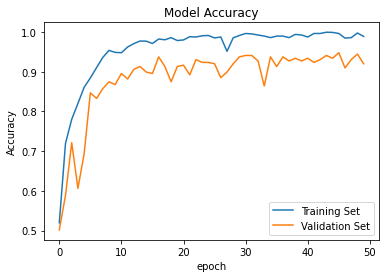

In [16]:
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Training Set', 'Validation Set'], loc='lower right')
plt.show()

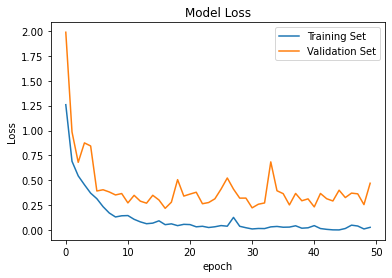

In [17]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Training Set', 'Validation Set','Testing Set'], loc='upper right')
plt.show()

Plot confusion matrix

In [18]:
predictions = m1.predict(x_test)
y_preds = np.argmax(predictions, axis=1)
y_labels = np.argmax(y_test, axis=1)

In [19]:
cm = tf.math.confusion_matrix(y_labels, y_preds, num_classes=4)
cm = np.array(cm)

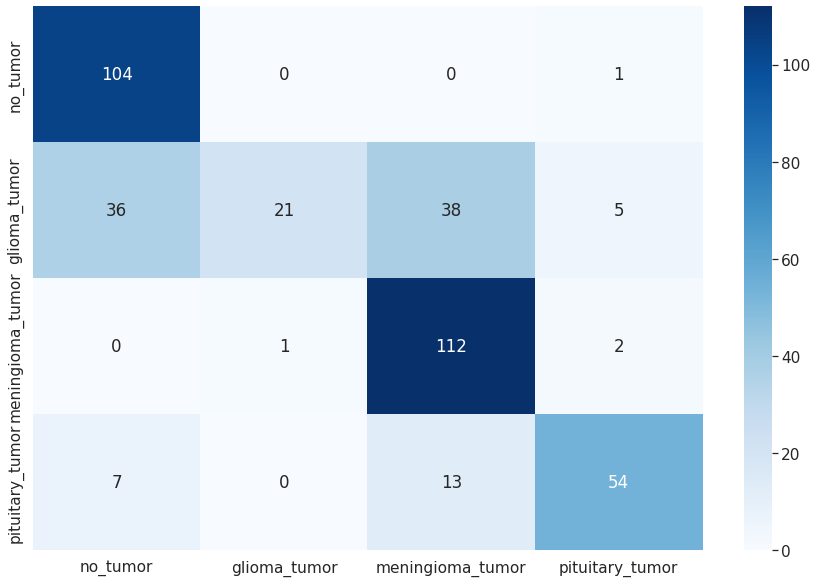

In [21]:
df_cm = pd.DataFrame(cm, labels, labels)
plt.figure(figsize=(15,10))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt="d") # font size
plt.show()

Save model

In [25]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
m1.save("mymodel")
reconstructed_model = keras.models.load_model("mymodel")

INFO:tensorflow:Assets written to: mymodel/assets
